# GOAL OF THE PROJECT

**`Predict target feature first and foremost by geometrical parameters`**

# IMPORTING LIBRARIES

In [639]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm as cmaps
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import re
import seaborn as sns
from scipy import stats
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print("Packages loaded!")

Packages loaded!


# Pipeline Controller

df = load_original_data()
df_cleaned = delete_unncessary_columns(df)
df_cleaned = make_columns_lowercase(df_cleaned)
df_cleaned = delete_non_legit_XDC_IDs(df_cleaned)
df_cleaned, date_columns = date_columns_transform_into_datetime(df_cleaned)
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])
df_cleaned = substitute_familie_int_str(df_cleaned)
df_cleaned = add_date_month_string_columns(df_cleaned, date_columns)
df_cleaned = string_comma_to_dot_float(df_cleaned)
#df_cleaned = clean_personal_names(df_cleaned)

# READ DATA INTO DATAFRAME FROM EXISTING .CSV

In [652]:
def load_original_data():
    """
    Read production data and parse into pandas dataframe.
    """
    latest_file = r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\DA_Midterm_Project\_Data\Production_Data.csv"
    df_prod_whole = pd.read_csv(latest_file, sep=";", encoding = "ISO-8859-1")
    
    return df_prod_whole

df_prod_whole = load_original_data()

# DF CLEANING

## Make columns lowercase and fix syntax

In [641]:
def make_columns_lowercase(df):
    
    lower_cols = [i.lower().replace(" ", "_").replace("-", "_") for i in df.columns]
    df.columns = lower_cols    
    
    return df

df_cleaned = make_columns_lowercase(df_prod_whole)

## Remove rows with XDC-ID < `68.000`

In [642]:
def delete_rows_with_XDC_ID_pre_68k(df):
    """
    Delete all entries before XDC-ID 68.000 due to them having wrong defect IDs.
    Only applies if dataframe actually has older entries with XDC-IDs < 68.000
    """
    
    df = df[df["pdc_nummer"]>=68000]
    
    return df

df_cleaned = delete_rows_with_XDC_ID_pre_68k(df_prod_whole)

## Remove rows without entries in selected columns

def delete_rows_with_nan_in_selected_cols(df, cols):
    """
    Delete rows that do not have an entry in the given columns
    """
    for col in cols:
        df[col].dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
        
    return df
    
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])

## Delete unncessary/empty colums

In [643]:
len(df_cleaned.columns)

195

In [644]:
def delete_unncessary_columns(df):
    """
    Delete columns only containing NaN values or columns with effectively useless data
    """
    #try:
    columns_to_drop = []    

    partial_col_strings_to_drop = ["datum", "wt1", "wt2", "ort", "geraet", "defekt", "charge",
                                  "kommentar", "offset", "uebergabe", "id", "kanal", "version",
                                  "coating", "versand", "shore", "linear", "auslenkung", "et2", "ft2",
                                  "schneiden", "schleifen", "assembl", "grenzwert", "personal"]

    for drop_col in partial_col_strings_to_drop:
        columns_to_drop.extend([col for col in df.columns if drop_col in col.lower()])

    columns_to_drop.extend(['versand_intern',
                             'ssma_timestamp',
                             'assembley_teflonschlauch_charge',
                             'pdc_nummer',
                             'dose', "ft1_typ", "ek_groesse"])
    
    df.drop(columns=columns_to_drop, inplace=True)

    #except:
        #raise ValueError("Deleting columns was unsuccessful!")
    
    return df

df_cleaned = delete_unncessary_columns(df_prod_whole)

In [645]:
len(df_cleaned.columns)

29

## Drop unnecessary `Familie` type

In [646]:
def substitute_familie_int_str(df):
    """
    Only keep PDCs (1) // PDC-Cs 
    """
    
    df = df[(df["familie"]==1)]
        
    return df

df_cleaned = substitute_familie_int_str(df_cleaned)

## Turn string-comma-values into dot-float-values

In [647]:
def string_comma_to_dot_float(df):
    """
    Cast string-comma-values as dot-float-values
    """
    cols_to_use = ['ns1_winkel_vorne','ns1_winkel_hinten','ns1_durchmesser_vorne','ns1_durchmesser_hinten',
               "ns2_center_variation", "ns2_front_angle","ns2_curve","ns2_15xlength",
               "ns2_parabolic_factor","oeo_oeo", "piezo_phase"] 

    for column in cols_to_use:
        df[column] = [float(str(x).replace(',','.')) for x in df[column]] 
     
    return df

df_cleaned = string_comma_to_dot_float(df_cleaned)

## Clean personal (operator) initials

def clean_personal_names(df):
    """
    Func descr
    """
    
    replacements = {'GD': 'GDH',
                    'MFW': 'MFE',
                    "ME": "MFE",
                    "MF": "MFE",
                    "LAE": "AL",
                    "SF": "SFZ",
                    "DC": "AC",
                    "THANH": "TT",
                    "?": np.nan}
    
    personal_cols = [col for col in df_cleaned.columns if "personal" in col]
    
    for col in personal_cols:
        op_list = []

        for op in df_cleaned["ft1_personal"]:
            if type(op)==str and op.isalpha():
                op_list.append(op.upper())
            elif op=="?":
                op_list.append(np.nan)
            elif type(op)==str and "." in op:
                op_list.append(np.nan)
            elif type(op)==str and not op.isalpha() and op!="?":
                op_list.append(op[:re.search(r'\W+', op).start()].upper())
            else:
                op_list.append(np.nan)

        op_list = [replacements.get(word, word) for word in op_list]

        df[col] = op_list
        
    return df
    
#df_cleaned = clean_personal_names(df_cleaned)

In [648]:
df_cleaned.columns

Index(['produktion_groesse', 'familie', 'art', 'ns1_winkel_vorne',
       'ns1_winkel_hinten', 'ns1_durchmesser_vorne', 'ns1_durchmesser_hinten',
       'ns2_center_variation', 'ns2_front_angle', 'ns2_curve', 'ns2_15xlength',
       'ns2_parabolic_factor', 'oeo_oeo', 'kleben1_kleber_teilentnahme',
       'kleben2_kleber_teilentnahme', 'bqc_spannung', 'bqc_puls',
       'bqc_volumen', 'et1_spannung', 'et1_puls', 'et1_volumen',
       'ft1_spannung', 'ft1_puls', 'ft1_volumen', 'ek_spannung', 'ek_puls',
       'ek_volumen', 'piezo_position', 'piezo_phase'],
      dtype='object')

## Rename different QC columns to generic form

In [649]:
def rename_qc_columns(df):
    """
    Func descr
    """
    
    df.rename(columns={'bqc_volumen': 'qc1_volumen', 
                         'et1_volumen': 'qc2_volumen',
                        'ft1_volumen': 'qc3_volumen',
                        'ek_volumen': 'qc4_volumen',

                        'bqc_spannung': 'qc1_spannung', 
                         'et1_spannung': 'qc2_spannung',
                        'ft1_spannung': 'qc3_spannung',
                        'ek_spannung': 'qc4_spannung',

                        'bqc_puls': 'qc1_puls', 
                         'et1_puls': 'qc2_puls',
                        'ft1_puls': 'qc3_puls',
                        'ek_puls': 'qc4_puls'}, inplace=True)
    
    return df

df_cleaned = rename_qc_columns(df_cleaned)

# PROCESSING `NUMERICAL` DATA

**`SHOW RELATIONSHIP BETWEEN VOLUME, PULSE, VOLTAGE IN DIFFERENT QCs`**

In [655]:
df_qc_vol_check = df_cleaned[["qc1_volumen", "qc2_volumen", "qc3_volumen", "qc4_volumen"]]
df_qc_vol_check.dropna(axis=0, inplace=True)
df_qc_vol_check.reset_index(drop=True, inplace=True)

In [656]:
df_qc_vol_check

,qc1_volumen,qc2_volumen,qc3_volumen,qc4_volumen
0,418.00,414.00,422.00,413.00
1,411.00,406.00,418.00,409.00
2,393.00,401.00,400.00,410.00
3,413.00,407.00,409.00,415.00
4,412.00,412.00,413.00,416.00
...,...,...,...,...
11470,200.00,210.00,240.00,221.00
11471,414.00,446.00,399.00,405.00
11472,458.00,500.00,535.00,532.00
11473,492.00,503.00,466.00,492.00


In [613]:
# AVG ALL QC_VOLUMEs TO YIELD SINGLE TARGET FEATURE
qc1_vol = df_cleaned["qc1_volumen"]
qc2_vol = df_cleaned["qc2_volumen"]
qc3_vol = df_cleaned["qc3_volumen"]
qc4_vol = df_cleaned["qc4_volumen"]

# AVG ALL QC_VOLTAGEs
qc1_voltage = df_cleaned["qc1_spannung"]
qc2_voltage = df_cleaned["qc2_spannung"]
qc3_voltage = df_cleaned["qc3_spannung"]
qc4_voltage = df_cleaned["qc4_spannung"]

# AVG ALL QC_PULSEs
qc1_pulse = df_cleaned["qc1_puls"]
qc2_pulse = df_cleaned["qc2_puls"]
qc3_pulse = df_cleaned["qc3_puls"]
qc4_pulse = df_cleaned["qc4_puls"]

qc_volumes = list(zip(qc1_vol, qc2_vol, qc3_vol, qc4_vol))
qc_voltages = list(zip(qc1_voltage, qc2_voltage, qc3_voltage, qc4_voltage))
qc_pulses = list(zip(qc1_pulse, qc2_pulse, qc3_pulse, qc4_pulse))

qc_volume_means = [np.nanmean(volume) for volume in qc_volumes]
qc_voltage_means = [np.nanmean(voltage) for voltage in qc_voltages]
qc_puls_means = [np.nanmean(puls) for puls in qc_pulses]

# ADD NEW QC_MEAN COLUMNS TO DF
df_cleaned["qc_volume_mean"] = qc_volume_means
df_cleaned["qc_voltage_mean"] = qc_voltage_means
df_cleaned["qc_puls_mean"] = qc_puls_means

# DROP SPECIFIC QC VOLUME, VOLTAGE, PULS COLUMNS & ONLY KEEP AVERAGED COLS
df_cleaned.drop(columns=["qc1_volumen", "qc2_volumen", "qc3_volumen","qc4_volumen",
                        "qc1_spannung","qc2_spannung","qc3_spannung","qc4_spannung",
                        "qc1_puls","qc2_puls","qc3_puls","qc4_puls"], inplace=True)

In [ ]:
# GET NUMERICAL FEATURES FROM DATAFRAME
df_numerical = df_cleaned.select_dtypes(include=np.number)

# DROP CATEGORICAL FEATURES FROM NUMERICAL DATAFRAME
df_numerical.drop(columns=["produktion_groesse", "piezo_phase", "art", "familie",
                          "kleben1_kleber_teilentnahme",
                          "kleben2_kleber_teilentnahme"], inplace=True)

sns.pairplot(df_numerical)

In [614]:
# DROP ROWS WHERE QC VOLUME, VOLTAGE, PULSE IS BELOW/ABOVE CRITICAL, SENSIBLE THRESHOLD
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns1_durchmesser_vorne"]>0) &
                       (df_cleaned["ns1_durchmesser_vorne"]<=100)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns1_durchmesser_hinten"]>0) &
                       (df_cleaned["ns1_durchmesser_hinten"]<=90)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns2_15xlength"]>0) &
                       (df_cleaned["ns2_15xlength"]<=7)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns2_parabolic_factor"]>=29) &
                       (df_cleaned["ns2_parabolic_factor"]<=37)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns2_center_variation"]>=0) &
                       (df_cleaned["ns2_center_variation"]<=1.4)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["ns2_front_angle"]>0) &
                       (df_cleaned["ns2_front_angle"]<=1.2)]
#print(len(df_cleaned))
#df_cleaned = df_cleaned[(df_cleaned["ns2_curve"]>=0) &
                       #(df_cleaned["ns2_curve"]<=4)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["oeo_oeo"]>=30) &
                       (df_cleaned["oeo_oeo"]<=70)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_volume_mean"]>=150) &
                       (df_cleaned["qc_volume_mean"]<=650)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_voltage_mean"]>=50) &
                       (df_cleaned["qc_voltage_mean"]<=170)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_puls_mean"]>=40) &
                       (df_cleaned["qc_puls_mean"]<=55)]

df_cleaned.reset_index(drop=True, inplace=True)
print(len(df_cleaned))

104702
103175
103101
55270
53508
50777
48955
37640
27981
27383
27020


## Processing NaN values - Categoricals

### Fill NaN values with mode in respective personal columns

### Fill missing place with P distribution, where 67% of the time the product comes from Berlin

df_categorical["schmelzen_ort"].fillna(random.choices(['Berlin', 'Dortmund'], 
                                                      weights=[0.67, 0.33], k=1)[0], inplace=True)

### Fill NaN values of produktion_groesse with static value 1

df_categorical["produktion_groesse"].fillna(1, inplace=True)

### Fill NaN kleben1_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 5 --> based on procedural limits*

df_categorical["kleben1_kleber_teilentnahme"].fillna(int(np.mean(
    [int(k1e) for k1e in list(df_categorical["kleben1_kleber_teilentnahme"].unique()) if 6 > k1e > 0])), inplace=True)

### Fill NaN kleben2_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 6 --> based on procedural limits*

df_categorical["kleben2_kleber_teilentnahme"].fillna(
    int(np.mean([int(k1e) for k1e in list(df_categorical["kleben2_kleber_teilentnahme"].unique()) if 7 > k1e > 0])), inplace=True)

### Fill NaN piezo_phase with average of non-zero entries

## Splitting numerical and categorical data

def get_numerical(df):
    
    df_edanum = df_cleaned.select_dtypes(include=np.number)

    ns1_cols = [col for col in df_edanum.columns if "ns1" in col if 'geraet' not in col]
    ns2_cols = [col for col in df_edanum.columns if "ns2" in col if 'geraet' not in col]
    piezo_cols = [col for col in df_edanum.columns if "piezo" in col]
    oeo_cols=[col for col in df_edanum.columns if "oeo" in col]
    vol_cols = [col for col in df_edanum.columns if "volume" in col]
    span_cols =[col for col in df_edanum.columns if "spannung" in col]
    pulse_col = [col for col in df_edanum.columns if "puls" in col]

    columns_to_use = ns1_cols + ns2_cols + piezo_cols + oeo_cols + span_cols + pulse_col + vol_cols

    df_numerical = df_edanum[columns_to_use]
    
    df_numerical.rename(columns={'bqc_volumen': 'qc1_volumen', 
                                 'et1_volumen': 'qc2_volumen',
                                'ft1_volumen': 'qc3_volumen',
                                'ek_volumen': 'qc4_volumen',
                                 
                                'bqc_spannung': 'qc1_spannung', 
                                 'et1_spannung': 'qc2_spannung',
                                'ft1_spannung': 'qc3_spannung',
                                'ek_spannung': 'qc4_spannung',
                                 
                                'bqc_puls': 'qc1_puls', 
                                 'et1_puls': 'qc2_puls',
                                'ft1_puls': 'qc3_puls',
                                'ek_puls': 'qc4_puls'}, inplace=True)
    
    return df_numerical

def get_categorical(df):
    df_categorical = df_cleaned.select_dtypes(include=['object'])
    
    cols_categorical = ["familie", 
                        'schmelzen_personal', "schmelzen_ort", 
                        'ns1_personal', 'schneiden_personal', 'schleifen_personal',
                        'ns2_personal', 'oeo_personal', 
                        'kleben1_personal', 'kleben2_personal',
                        'bqc_personal', 'et1_personal', 'ft1_personal', 'ek_personal']
    
    df_categorical = df_categorical[cols_categorical]
    
    df_categorical["produktion_groesse"] = df_cleaned["produktion_groesse"]
    df_categorical["art"] = df_cleaned["art"]
    df_categorical["kleben1_kleber_teilentnahme"] = df_cleaned["kleben1_kleber_teilentnahme"]
    df_categorical["kleben2_kleber_teilentnahme"] = df_cleaned["kleben2_kleber_teilentnahme"]

    return df_categorical

#df_numerical = get_numerical(df_cleaned)
#df_categorical = get_categorical(df_cleaned)

In [615]:
# GET NUMERICAL FEATURES FROM DATAFRAME
df_numerical = df_cleaned.select_dtypes(include=np.number)

# DROP CATEGORICAL FEATURES FROM NUMERICAL DATAFRAME
df_numerical.drop(columns=["produktion_groesse", "piezo_phase", "art", "familie",
                          "kleben1_kleber_teilentnahme",
                          "kleben2_kleber_teilentnahme"], inplace=True)

# ELIMINATE OUTLIERS BY FILTERING DATA THROUGH RESPECTIVE MIN/MAX THRESHOLDS FOR FEATURE

num_feature_min_limits = [40, 39, 0, 0, 19, 30, 150, 50, 40]
num_feature_max_limits = [100, 90, 1.4, 1.2, 37, 70, 650, 170, 55]
num_feature_to_limit = ["ns1_durchmesser_vorne", "ns1_durchmesser_hinten",
                        "ns2_front_angle", "ns2_curve", "ns2_parabolic_factor",
                        "oeo_oeo",
                        "qc_volume_mean", "qc_voltage_mean", "qc_puls_mean"]

for col in range(len(num_feature_to_limit)):
    df_numerical = df_numerical[(df_numerical[num_feature_to_limit[col]] >= num_feature_min_limits[col]) &
                               (df_numerical[num_feature_to_limit[col]] <= num_feature_max_limits[col])]\
    .reset_index(drop=True)

#df_numerical["ns1_durchmesser_vorne"].describe() # min 0.0
#df_numerical["ns1_durchmesser_hinten"].describe() # min 0.0
#df_numerical["ns2_front_angle"].describe() # max 3.1
#df_numerical["ns2_curve"].describe() # max 8.3
#df_numerical["ns2_parabolic_factor"].describe() # max 87
#df_numerical["oeo_oeo"].describe() # min 0.0
df_numerical["qc_volume_mean"].describe(),\
df_numerical["qc_voltage_mean"].describe(),\
df_numerical["qc_puls_mean"].describe()

# CHECK OUTLIERS IN NUMERICAL DATAFRAME
for col in df_numerical.columns:
    df_numerical[col].plot.box()
    plt.show()

## Check multicollinearity for numerical features

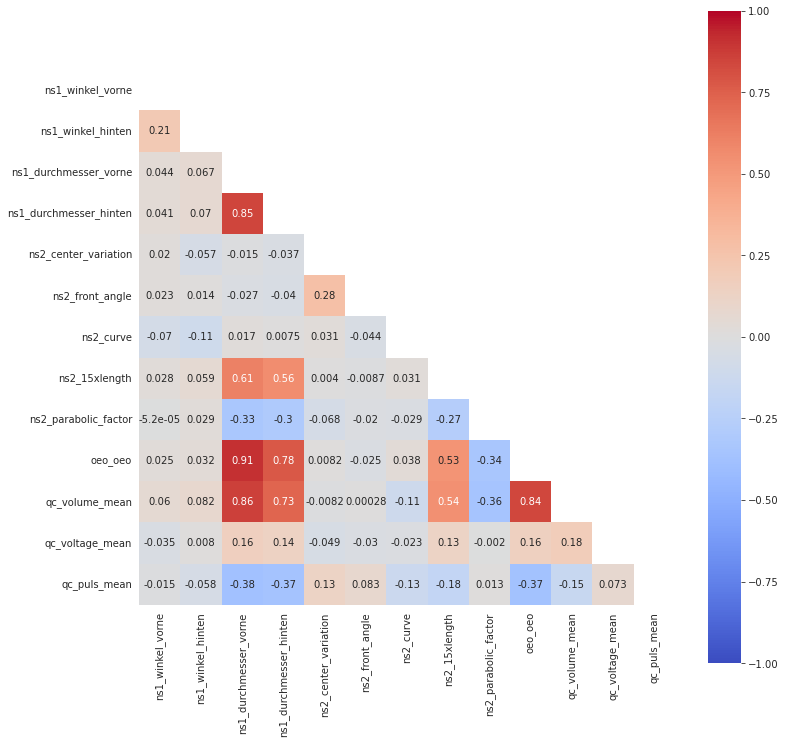

In [616]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [617]:
def show_and_drop_high_correlation_features(df, threshold):
    """
    Show any features that have correlation higher than threshold with any other;
    """
    corr_matrix=df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    
    cols_above_threshold = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    cols_above_threshold = [col for col in cols_above_threshold if "volume" not in col]
    df = df.drop(columns=cols_above_threshold)
    return df

df_numerical = show_and_drop_high_correlation_features(df_numerical, 0.8)

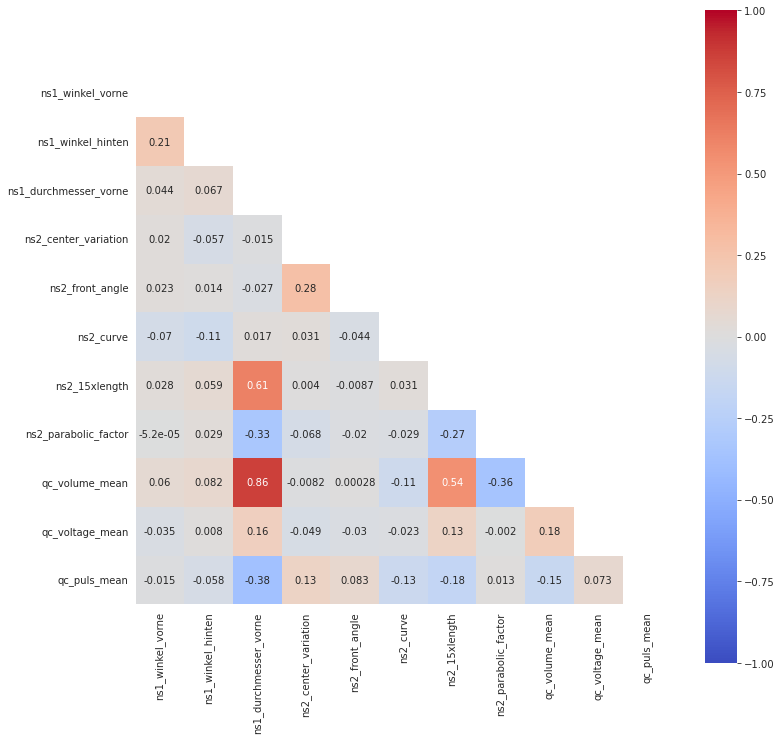

In [618]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Hot-Encode categorical features

#df_complete_BQC_categorical_hotcoded = pd.get_dummies(df_complete_BQC_categorical, drop_first=True)

df_categorical_hotcoded = pd.get_dummies(df_categorical, drop_first=True)


# Linear Regression

df_numerical_categorical = pd.concat((df_categorical_hotcoded, df_numerical), axis=1)

df_numerical_categorical = df_numerical_categorical[df_numerical_categorical["qc_vol_mean"]>0].reset_index(drop=True)

#df_numerical_categorical.dropna(axis=0, inplace=True)

## X-y Split

In [619]:
#df_to_use = df_numerical_complete_BQC_categorical
print("Rows before dropping NaN values: ", len(df_numerical))
df_to_use = df_numerical.dropna(axis=0)
print("Rows after dropping NaN values: ", len(df_to_use))

Rows before dropping NaN values:  27020
Rows after dropping NaN values:  27020


sns.pairplot(df_to_use)

In [633]:
#X = df_to_use.drop('qc_volume_mean', axis=1)
X = df_to_use.drop(['qc_volume_mean', 
                    'qc_voltage_mean', 'qc_puls_mean', "ns2_curve"], axis=1) #, 'qc_voltage_mean', 'qc_puls_mean'
y = df_to_use["qc_volume_mean"]

## Train - Test - Split

In [634]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,random_state=42)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (18914, 7)
Shape X_test: (8106, 7)
Shape y_train: (18914,)
Shape y_test: (8106,)


## Standardize the data after data split

In [635]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)
print("Coefficients: ", model.intercept_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(18914, 7) (8106, 7)
Coefficients:  [ 1.03224683  1.17974846 44.01331944 -0.24825699  1.19093389  0.47178516
 -4.42335747]
Coefficients:  375.86547002220567


## Evaluating Model Performance

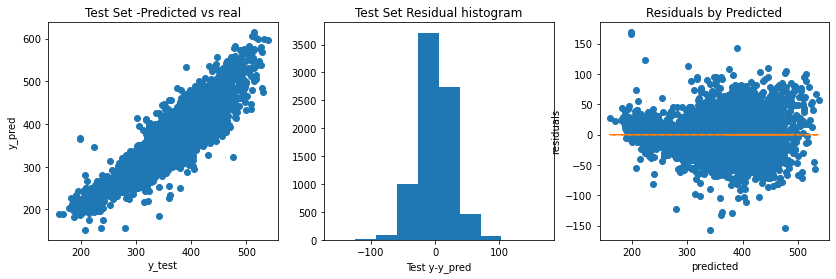

In [636]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

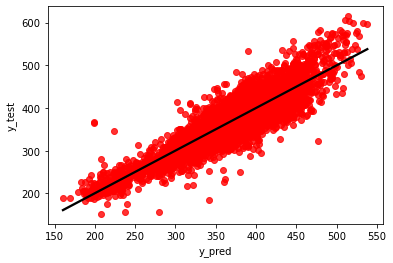

In [637]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

## Error metrics

In [638]:
mse_1 = round(mse(y_test,y_pred),2)
rmse_1 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_1 = round(mae(y_test,y_pred),2)

print("MSE:", mse_1) # shows squared error (harder to interpret)
print("RMSE:", rmse_1) # shows error
print("MAE:", mae_1) # shows real error (in $)
print("-----")

# R^2
R2_1 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_1 = round(1 - (1-R2_1)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) only> is {round(R2_1,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) only> is {round(Adj_R2_1,2)}.")

MSE: 698.37
RMSE: 26.43
MAE: 20.27
-----
R^2 for <numerical (with outliers) only> is 0.76.
Adjusted R^2 for <numerical (with outliers) only> is 0.76.


**`OBSERVATIONS`**
- When not filtering on ns2_cv and ns2_fa, R2 increases from 0.72 to 0.82
- Changing random seed has significant impact (~ +/- 0.05) on R2


- not filtering on ns2_cv / ns2_fa / ns2_curve + seed = 6969 --> R2 = 0.8
- not filtering on ns2_cv / ns2_fa / ns2_curve + seed = 42 --> R2 = 0.79
- not filterin ns2_curve + seed 6969 --> R2 = 0.78
- filtering on all + seed 6969 --> R2 = 0.76
- not filtering on qc_voltages / qc_pulses + seed 6969 --> R2 = 0.55


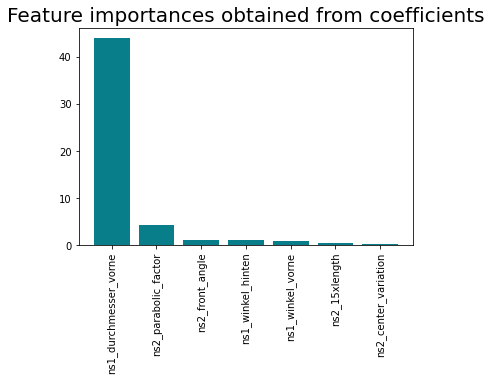

In [653]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False)

plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Lasso Regression